This notebook contains an example for teaching.


# Automatic Machine Learning with H2O AutoML 

We illustrate how to predict an outcome variable Y in a high-dimensional setting, using the AutoML package *H2O* that covers the complete pipeline from the raw dataset to the deployable machine learning model. In last few years, AutoML or automated machine learning has become widely popular among data science community. Again, re-analyse the wage prediction problem using data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.

We can use AutoML as a benchmark and compare it to the methods that we used in the previous notebook where we applied one machine learning method after the other.

In [8]:
# load the H2O package
install.packages("librarian", quiet = T)
librarian::shelf(h2o, tidyverse, quiet = T)
# library(h2o)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [9]:
# load the data set

data = read_csv("https://github.com/alexanderquispe/14.38_Causal_ML/raw/main/data/wage2015_subsample_inference.csv", show_col_types = F)

# split the data
set.seed(1234)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

train <- data[training,]
test <- data[-training,]

In [10]:
# start h2o cluster
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp04tHzQ/file3c5628322d/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp04tHzQ/file3c7321dc6f/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 645 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.1.2 
    H2O cluster version age:    1 month and 23 days  
    H2O cluster name:           H2O_started_from_R_root_tlg556 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:    

In [11]:
# convert data as h2o type
train_h = as.h2o(train)
test_h = as.h2o(test)

# have a look at the data
h2o.describe(train_h)

  |======================================================================| 100%
  |======================================================================| 100%


Label,Type,Missing,Zeros,PosInf,NegInf,Min,Max,Mean,Sigma,Cardinality
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rownames,int,0,0,0,0,10.000000,3.264300e+04,1.560586e+04,9.721144e+03,NA
wage,real,0,0,0,0,3.021978,5.288457e+02,2.337760e+01,2.060944e+01,NA
lwage,real,0,0,0,0,1.105912,6.270697e+00,2.969673e+00,5.721780e-01,NA
sex,int,0,2115,0,0,0.000000,1.000000e+00,4.523563e-01,4.977894e-01,NA
shs,int,0,3770,0,0,0.000000,1.000000e+00,2.382185e-02,1.525136e-01,NA
hsg,int,0,2896,0,0,0.000000,1.000000e+00,2.501295e-01,4.331435e-01,NA
scl,int,0,2795,0,0,0.000000,1.000000e+00,2.762817e-01,4.472157e-01,NA
clg,int,0,2646,0,0,0.000000,1.000000e+00,3.148628e-01,4.645213e-01,NA
ad,int,0,3341,0,0,0.000000,1.000000e+00,1.349042e-01,3.416654e-01,NA


In [12]:
# define the variables
y = 'lwage'
x = setdiff(names(data), c('wage','occ2', 'ind2'))
            
# run AutoML for 10 base models and a maximal runtime of 100 seconds
aml = h2o.automl(x=x,y = y,
                  training_frame = train_h,
                  leaderboard_frame = test_h,
                  max_models = 10,
                  seed = 1,
                  max_runtime_secs = 100
                 )
# AutoML Leaderboard
lb = aml@leaderboard
print(lb, n = nrow(lb))

Warning message in .verify_dataxy(training_frame, x, y):
“removing response variable from the explanatory variables”


  |======================================================================| 100%
                                                  model_id      rmse       mse
1     StackedEnsemble_AllModels_1_AutoML_1_20220719_171824 0.4669942 0.2180836
2  StackedEnsemble_BestOfFamily_1_AutoML_1_20220719_171824 0.4690110 0.2199713
3                           GBM_1_AutoML_1_20220719_171824 0.4709260 0.2217713
4                           GBM_2_AutoML_1_20220719_171824 0.4724988 0.2232551
5                           GBM_3_AutoML_1_20220719_171824 0.4733774 0.2240862
6                           GBM_4_AutoML_1_20220719_171824 0.4740358 0.2247100
7                       XGBoost_3_AutoML_1_20220719_171824 0.4791050 0.2295416
8                           XRT_1_AutoML_1_20220719_171824 0.4884560 0.2385893
9                           DRF_1_AutoML_1_20220719_171824 0.4893117 0.2394260
10                      XGBoost_2_AutoML_1_20220719_171824 0.5039629 0.2539786
11                      XGBoost_1_AutoML_1_20220719

We see that two Stacked Ensembles are at the top of the leaderboard. Stacked Ensembles often outperform a single model. The out-of-sample (test) MSE of the leading model is given by

In [13]:
aml@leaderboard$mse[1]

        mse
1 0.2180836

[1 row x 1 column] 

The in-sample performance can be evaluated by

In [14]:
aml@leader

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_1_AutoML_1_20220719_171824 
Number of Base Models: 10

Base Models (count by algorithm type):

    drf     gbm     glm xgboost 
      2       4       1       3 

Metalearner:

Metalearner algorithm: glm
Metalearner cross-validation fold assignment:
  Fold assignment scheme: AUTO
  Number of folds: 5
  Fold column: NULL
Metalearner hyperparameters: 


H2ORegressionMetrics: stackedensemble
** Reported on training data. **

MSE:  0.1415518
RMSE:  0.3762337
MAE:  0.2857554
RMSLE:  0.09723326
Mean Residual Deviance :  0.1415518



H2ORegressionMetrics: stackedensemble
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.219355
RMSE:  0.4683535
MAE:  0.3549446
RMSLE:  0.1199425
Mean Residual Deviance :  0.219355


Cross-Validation Metrics Summary: 
                             mean        sd cv_1_valid cv_2_va

This is in line with our previous results. To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [15]:
model_ids <- as.data.frame(aml@leaderboard$model_id)[,1]
# Get the "All Models" Stacked Ensemble model
se <- h2o.getModel(grep("StackedEnsemble_AllModels", model_ids, value = TRUE)[1])
# Get the Stacked Ensemble metalearner model
metalearner <- se@model$metalearner_model
h2o.varimp(metalearner)

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
GBM_1_AutoML_1_20220719_171824,0.092798688,1.00000000,0.276345757
GBM_2_AutoML_1_20220719_171824,0.089138567,0.96055849,0.265446264
XGBoost_3_AutoML_1_20220719_171824,0.054892909,0.59152678,0.163465916
GBM_3_AutoML_1_20220719_171824,0.034995779,0.37711503,0.104214137
GBM_4_AutoML_1_20220719_171824,0.032231744,0.34732974,0.095983101
XGBoost_2_AutoML_1_20220719_171824,0.016404439,0.17677447,0.048850875
XGBoost_1_AutoML_1_20220719_171824,0.012321778,0.13277965,0.036693094
GLM_1_AutoML_1_20220719_171824,0.003022545,0.03257099,0.009000855
XRT_1_AutoML_1_20220719_171824,0.000000000,0.00000000,0.000000000


The table above gives us the variable importance of the metalearner in the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 


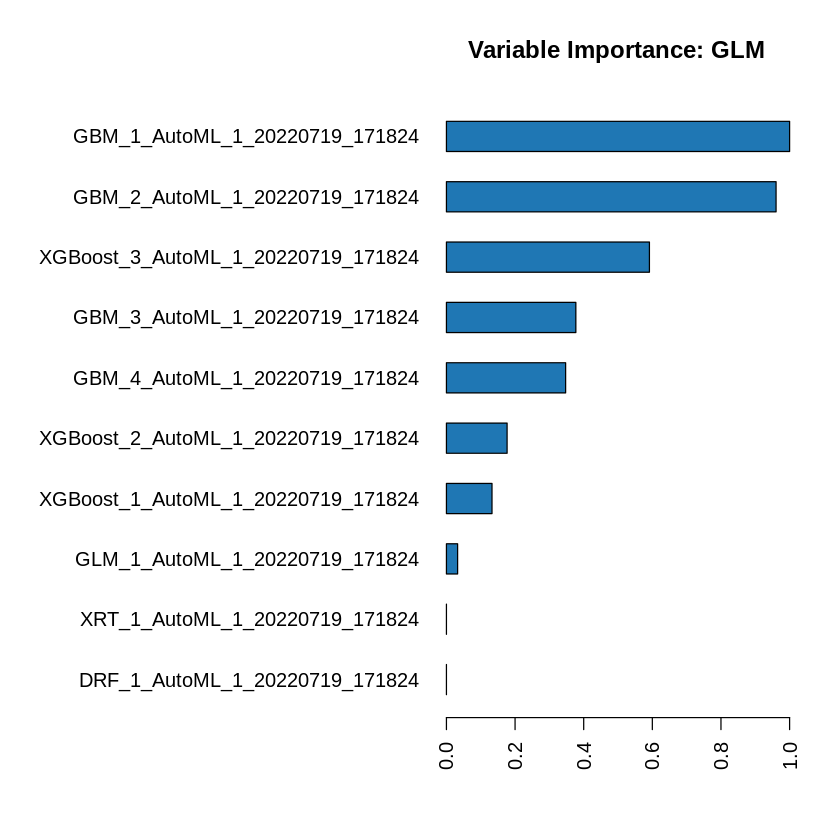

In [16]:
h2o.varimp_plot(metalearner)

## Generating Predictions Using Leader Model

We can also generate predictions on a test sample using the leader model object.

In [17]:
pred <- as.matrix(h2o.predict(aml@leader,test_h)) # make prediction using x data from the test sample
head(pred)

  |======================================================================| 100%


predict
3.028706
2.533245
2.823822
2.470121
2.776539
2.678759


This allows us to estimate the out-of-sample (test) MSE and the standard error as well.

In [18]:
y_test <- as.matrix(test_h$lwage)
summary(lm((y_test-pred)^2~1))$coef[1:2]

[1] 0.21808362 0.01495401

We observe both a lower MSE and a lower standard error compared to our previous results (see [here](https://www.kaggle.com/janniskueck/pm3-notebook-newdata)).

In [19]:
h2o.shutdown(prompt = F)